# Simple scenario

5x5 board, 2 players, each player has a single unit: GenericSoldier:
* health 100 
* damage 100 
* Attack range 2 
* speed 3

Games expected to end in 1-2 moves

## Boring code

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys

if '../..' not in sys.path: sys.path.append('../..')
from src.utils import *
from src.actions import *
from src.units import *
from src.game_utils import *
from src.agent import DnDAgent
from src.game_board import DnDBoard
from src.plot_utils import *

In [2]:
seed_everything(511)

In [3]:
def create_same_game(board_size = (5, 5), show_game=False, get_colormap=True):
    game = DnDBoard(board_size)

    ally = GenericSoldier("Ally soldier", health=100, attack_damage=100, speed=3, range=2)
    enemy = GenericSoldier("Enemy soldier", health=100, attack_damage=100, speed=3, range=2)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red"
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [4]:
def get_random_action_resolver(game):
    def random_action_resolver(state):
        legal_moves = get_legal_moves(game)
        new_pos = random.choice(list(zip(*np.where(legal_moves))))
        target_pos = random.choice(list(zip(*np.where(state[1]))))
        return (new_pos[0], target_pos[0]), (new_pos[1], target_pos[1])
    
    return random_action_resolver

In [5]:
def decode_action(game: DnDBoard, action_vector: tuple[np.ndarray[int], ...]):
    current_unit, player_id = game.get_current_unit()
    target_unit = game.board[action_vector[0][1], action_vector[1][1]]
    action = ActionInstance(current_unit.actions[0], source_unit=current_unit, target_unit=target_unit)
    return to_tuple((action_vector[0][0], action_vector[1][0])), action

In [6]:
def get_states(game, agent, random_action_resolver=None):
    state = game.observe_board()
    action_vector = agent.choose_action_vector(state, random_action_resolver)
    new_coords, action = decode_action(game, action_vector)

    return state, action_vector, new_coords, action

In [7]:
def self_play_loop(agent, game, color_map, random_action_resolver=None, delay=0.5):
    game_over = False
    iter_count = 0

    print_game(game, color_map)
    
    while not game_over:
        try:
            iter_count += 1

            time.sleep(delay)
            clear_output(wait=True)
            print(f'Iteration: {iter_count}')

            _, _, new_coords, action = get_states(game, agent, random_action_resolver)
            _, game_over = take_turn(game, new_coords, action, color_map, True)
        except KeyboardInterrupt:
            print(f'\nGame interrupted after {iter_count} iterations')
            return None

    print(f'\nGame over in {iter_count} iterations. Current epsilon = {agent.epsilon}')

    return iter_count

In [8]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard, random_action_resolver=None) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state, action_vector, new_coords, action = get_states(game, agent, random_action_resolver)
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_vector, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_vector
        last_reward = reward

    return iter_count

In [9]:
train_loop = train_loop_delayed # this one is actually bugged

## Create agent & train

In [10]:
agent = DnDAgent(lr=0.001, board_shape=(5, 5), epsilon_delta=1e-4, in_channels=7, out_actions=2, batch_size=128)
iters, eps = [], []

In [11]:
games = 4000

with tqdm(range(games), desc='Training') as pbar:
    for i in pbar:
        game = create_same_game(get_colormap=False)
        resolver = get_random_action_resolver(game)
        iter_count = train_loop(agent, game, resolver)
        iters.append(iter_count)
        eps.append(agent.epsilon)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

## Pretty plots

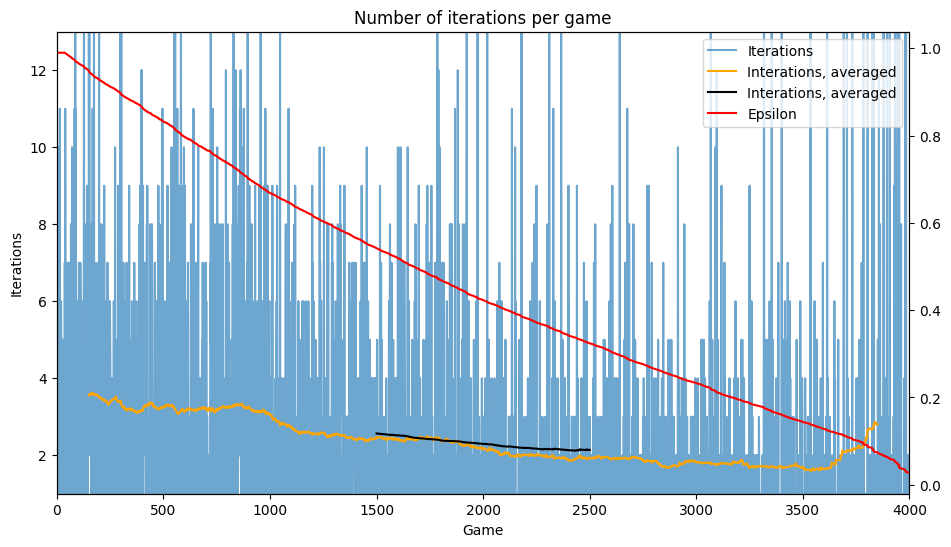

In [12]:
plot_training_history(iters, eps, ylim=13)

## Other visuals

In [13]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0         ██ 0 
 1            1 
 2   ██       2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`


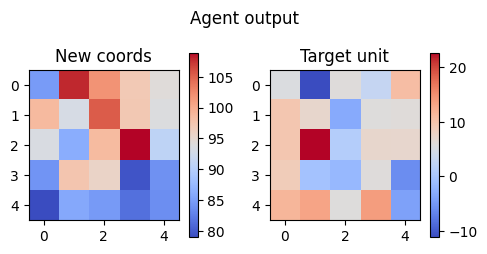

In [14]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

In [15]:
game, color_map = create_same_game()
epsilon = agent.epsilon
agent.epsilon = 0
self_play_loop(agent, game, color_map, delay=0.5)
agent.epsilon = epsilon

Iteration: 1
Turn made by player #1: `Enemy soldier`:
	Unit moves: (4, 4) -> (4, 1);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Enemy soldier', 'target_unit': 'Ally soldier'}

Units alive: 1
Players: 2:
	Player #0 (0 units):   
	Player #1 (1 units): `Enemy soldier (100 HP)`,   
	
    0 1 2 3 4
 0            0 
 1            1 
 2            2 
 3            3 
 4   ██       4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`

Game over in 1 iterations. Current epsilon = 0
